# Training siamese neural net

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import multiprocessing as mp
import itertools
import plotly.express as px
from scipy.stats import entropy
from functools import partial
import re
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import torch.nn.functional as F

cuda


## Data

In [174]:
# os.chdir("/data/jake/csci_7000-final_project")
os.chdir('/home/jake/ghub/csci-7000-006-neurosymbolic-nlp')

In [148]:
df_1kg = pd.read_csv("1kg-g2g_vecs.tsv",sep="\t", index_col=0)
df_pcawg = pd.read_csv("pcawg-g2g_vecs.tsv",sep="\t", index_col=0)
df_global = pd.concat([df_1kg, df_pcawg])
print(df_global.shape)
df_global.head()

(2677, 18721)


,ACYP2-AFF3,ACYP2-AGAP1,ACYP2-AP000304.12,ACYP2-APP,ACYP2-ARHGAP15,ACYP2-ARHGAP6,ACYP2-BACH1,ACYP2-CACNA2D3,ACYP2-CADM2,ACYP2-CCSER1,...,ZSWIM5-TTC28,ZSWIM5-ULK4,ZSWIM5-USH2A,ZSWIM5-VAV3,ZSWIM5-WDPCP,ZSWIM5-WWOX,ZSWIM5-ZBTB20,ZSWIM5-ZNF385D,ZSWIM5-ZNF536,ZSWIM5-ZRANB3
NA18614,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG01918,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,1,1,2
NA18546,1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HG02855,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
HG03565,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,1,1,1,1,1


In [175]:
d_tensor_1kg = torch.load("1kg-g2g-tensors.pt")
d_tensor_1kg

{'NA18614': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01918': tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32),
 'NA18546': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02855': tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32),
 'HG03565': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19324': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20527': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19107': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG01162': tensor([1, 2, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG02885': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA21126': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG00132': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA20332': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'NA19087': tensor([1, 1, 1,  ..., 2, 1, 1], dtype=torch.int32),
 'HG02035': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32),
 'HG03785': tensor([1, 1,

In [176]:
# scale to pdist range
for k,v in d_tensor_1kg.items():
    s = torch.sum(v)
    d_tensor_1kg[k] = v/s

In [177]:
# set tensor to float 32
for k,v in d_tensor_1kg.items():
    d_tensor_1kg[k] = v.to(torch.float32)

- Note: the l2 distances are already squared for ground truth: $||y||_{2}^{2}$


In [24]:
df_target_1kg = pd.read_csv("1kg-g2g_l2.tsv", sep="\t")
df_target_1kg.head()

,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324


- Q: is it better to scale the target vector or leave as is?
- **If scaled**, make sure to transform the embedding distance computed by the model while computing loss (see MSELoss).

<Axes: >

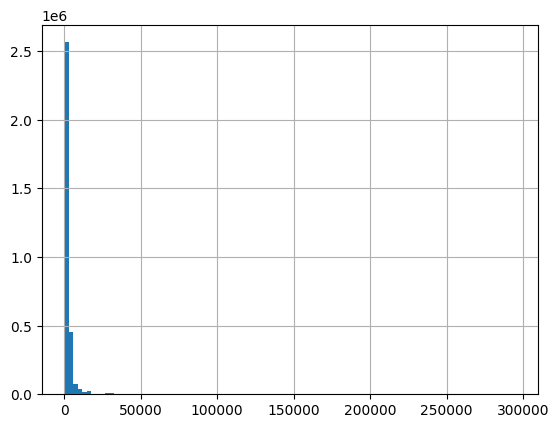

In [180]:
df_target['l2'].hist(bins=100)

- Note: standard scaler would center the targets around 0, however, I don't think it's straghtforward to z-score nomalize each embedding distance computed during training used to compute loss. There's probably a clever or complex way to do this, but it's out of the scope of this project. 

       l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
4  1244.0  NA18614  NA19324  7.126891


<Axes: >

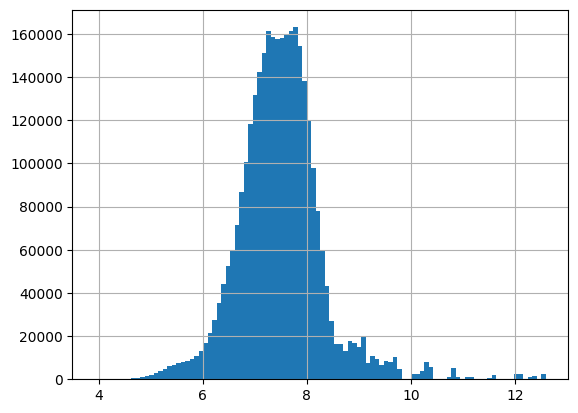

In [181]:
df_target['l2_log'] = df_target['l2'].apply(lambda x: np.log(x+1))
# apply standard scaler
# scaler = StandardScaler()
# df_target['l2_z_log'] = scaler.fit_transform(df_target['l2_z_log'].values.reshape(-1,1))
# df_target['l2_z_log'].hist(bins=100)
print(df_target.head())
df_target['l2_log'].hist(bins=100)

## Model 1kg

In [193]:
class SiameseDataset(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset (which is the number of samples)
        # len(d_tensor), but this is a lot of data per epoch
        # instead, a sampling pairs approach is used
        self.n_samples = n_samples
        self.scaled_target = scaled_target

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        pair = self.df_target.sample(1)
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        if self.scaled_target:
            target = torch.tensor(pair["l2_log"].values[0], dtype=torch.float32)
        else:
            target = torch.tensor(pair["l2"].values[0], dtype=torch.float32)
        return t1, t2, target

- Quick method for hold out

In [160]:
df_target_test = df_target.sample(1000, random_state=0)
# exclude test from train
# df_target_train = df_target[~df_target.index.isin(df_target_test.index)]
# print(len(df_target_train), len(df_target_test), len(df_target))

- Note: A less stringent approach could be employed

It could be allowed that any sample can be seen during training, yet not allowing for an 
exact pair in the test data set to be seen during training.

- However, I'm using the stringent approach of excluding any sample in the test pairs from the training data

In [183]:
test_samples = pd.concat([df_target_test['s_i'], df_target_test['s_j']]).unique()
test_samples.shape

(1395,)

In [184]:
# filter out test samples
df_target_train = df_target[~df_target['s_i'].isin(test_samples) & ~df_target['s_j'].isin(test_samples)]
print(len(df_target_train), len(df_target_test), len(df_target))
# show that the test samples are not in the train set
print(pd.concat([df_target_train['s_i'], df_target_train['s_j']]).nunique(), len(test_samples))
df_target_train.head()

649230 1000 3211845
1140 1395


,l2,s_i,s_j,l2_log
0,2099.0,NA18614,HG01918,7.649693
1,2988.0,NA18614,NA18546,8.002694
2,1381.0,NA18614,HG02855,7.231287
3,1468.0,NA18614,HG03565,7.292337
5,1670.0,NA18614,NA20527,7.421178


In [188]:
# no need to subset the tensor dictionary since we sample from the target dataframe
# which is paritioned for training samples only
dataset = SiameseDataset(d_tensor_1kg, df_target_train, n_samples=1000,scaled_target=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

It's a bit confusing since the targets are transformed, but here's another reminder:

- Ground truth targets are squared l2 distances, which can optionally be log transformed.
- Therefore, the model l2 embedding distances need to be transformed by the same methods: squared and optional log.

In [113]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )
    def forward_one(self, x):
        # compute embedding
        return self.fc(x)

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### MSE Loss

In [114]:
class CustomMSELoss(nn.Module):
    def __init__(self, scaled_target=True):
        super(CustomMSELoss, self).__init__()
        self.scaled_target = scaled_target

    def forward(self, embedding_distance, target_distance):
        # note: the ground truths are *squared* l2 distances
        # this is handled for embedding distance outside of the loss function for now
        
        # if targets are log scaled,
        # also log scaled the embedding distances
        if self.scaled_target:
            embedding_distance = torch.log10(embedding_distance + 1)
            loss = torch.mean((embedding_distance - target_distance) ** 2) # mse
        loss = torch.mean((embedding_distance - target_distance) ** 2)
        return loss

### Triplet loss

In [4]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Normalize the embeddings to unit vectors
        anchor = F.normalize(anchor, p=2, dim=1)
        positive = F.normalize(positive, p=2, dim=1)
        negative = F.normalize(negative, p=2, dim=1)
        
        # Compute cosine similarity
        positive_similarity = F.cosine_similarity(anchor, positive)
        negative_similarity = F.cosine_similarity(anchor, negative)
        
        # Compute cosine distance
        distance_positive = 1 - positive_similarity
        distance_negative = 1 - negative_similarity
        # relu ensures loss is 0
        # since it could be negative if d_pos - d_neg + margin < 0
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        # mean over the batch
        return losses.mean()

### Train

In [205]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = CustomMSELoss(scaled_target=True) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

18721 512


In [ ]:
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 57.111915588378906
Epoch 1, batch 2, loss: 61.00520324707031
Epoch 1, batch 3, loss: 57.372093200683594
Epoch 1, batch 4, loss: 54.97993850708008
Epoch 1, batch 5, loss: 54.21558380126953
Epoch 1, batch 6, loss: 58.90021514892578
Epoch 1, batch 7, loss: 54.97606658935547
Epoch 1, batch 8, loss: 57.40986633300781
Epoch 1, batch 9, loss: 57.511070251464844
Epoch 1, batch 10, loss: 57.78569030761719
Epoch 1, batch 11, loss: 57.799522399902344
Epoch 1, batch 12, loss: 57.142181396484375
Epoch 1, batch 13, loss: 60.017494201660156
Epoch 1, batch 14, loss: 56.27006530761719
Epoch 1, batch 15, loss: 57.81557846069336
Epoch 1, batch 16, loss: 57.027950286865234
Epoch 1, loss: 917.3404350280762
Epoch 2, batch 1, loss: 60.122901916503906
Epoch 2, batch 2, loss: 54.96807861328125
Epoch 2, batch 3, loss: 57.09115219116211
Epoch 2, batch 4, loss: 55.314544677734375
Epoch 2, batch 5, loss: 56.308170318603516
Epoch 2, batch 6, loss: 54.53364181518555
Epoch 2, batch 7, loss: 58

In [ ]:
# ### this contains all code to get a converging model
# # block1
# class SiameseNetwork(nn.Module):
#     def __init__(self, input_dim, embedding_dim):
#         super(SiameseNetwork, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, embedding_dim),
#             nn.ReLU(),
#             nn.Linear(embedding_dim, embedding_dim),
#             nn.ReLU(),
#             nn.Linear(embedding_dim, embedding_dim)
#         )
#     def forward_one(self, x):
#         # compute embedding
#         return self.fc(x)

#     def forward(self, x1, x2):
#         out1 = self.forward_one(x1)
#         out2 = self.forward_one(x2)
#         return out1, out2
# # block2
# class CustomMSELoss(nn.Module):
#     def __init__(self, scaled_target=True):
#         super(CustomMSELoss, self).__init__()
#         self.scaled_target = scaled_target

#     def forward(self, embedding_distance, target_distance):
#         # note: the ground truths are *squared* l2 distances
#         # this is handled for embedding distance outside of the loss function for now
        
#         # if targets are log scaled,
#         # also log scaled the embedding distances
#         if self.scaled_target:
#             embedding_distance = torch.log10(embedding_distance + 1)
#             loss = torch.mean((embedding_distance - target_distance) ** 2) # mse
#         loss = torch.mean((embedding_distance - target_distance) ** 2)
#         return loss

# # block3
# input_dim = d_tensor_1kg["HG00096"].shape[0]
# embedding_dim = 512
# print(input_dim,embedding_dim)
# model = SiameseNetwork(input_dim, embedding_dim)
# model.to(device)
# criterion = CustomMSELoss(scaled_target=True) # using log scaled l2
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# n_epochs = 20
# # block4
# torch.set_num_threads(15) # using gpu, but set this just in case
# writer = SummaryWriter(log_dir="logs")
# for epoch in range(n_epochs):
#     model.train()
#     running_loss = 0.0
#     l = []
#     for i, data in enumerate(dataloader):
#         t1, t2, target = data
#         t1, t2, target = t1.to(device), t2.to(device), target.to(device)
#         # reset grad    
#         optimizer.zero_grad()
#         output1, output2 = model(t1, t2)
#         embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
#         loss = criterion(embedding_distance, target)
#         loss.backward()
#         optimizer.step()
#         l.append(loss.item())
#         running_loss += loss.item()
#         print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
#         writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
#     print(f"Epoch {epoch+1}, loss: {running_loss}")
# writer.close()

- Since all test samples were excluded, any combination of test samples can be used for evaluation at inference time
- For practical purposes, choose 1000 pairs ground truth versus predicted

In [207]:
df_target_test = df_target[(df_target['s_i'].isin(test_samples)) & (df_target['s_j'].isin(test_samples))]
print(df_target_test.shape)
df_target_test.head()

(972315, 4)


,l2,s_i,s_j,l2_log
12663,739.0,NA19324,HG02885,6.606650
12664,1874.0,NA19324,NA21126,7.536364
12665,1935.0,NA19324,HG00132,7.568379
12668,178.0,NA19324,HG02035,5.187386
12669,211.0,NA19324,HG03785,5.356586


In [208]:
df_target_test_sub = df_target_test.sample(1000, random_state=0)
print(df_target_test_sub.shape)
df_target_test_sub.head()

(1000, 4)


,l2,s_i,s_j,l2_log
539629,4587.0,NA19213,NA19431,8.431199
2023457,1780.0,HG00737,HG01843,7.484930
2276963,2391.0,HG02471,HG03108,7.779885
1279172,2511.0,HG02108,NA19378,7.828835
1403012,815.0,NA20778,HG02819,6.704414


In [213]:
# inference on test pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_test_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: NA19213, NA19431, target: 8.431199478249262, distance: 4.855306148529053
Pair: HG00737, HG01843, target: 7.484930283289661, distance: 3.2204277515411377
Pair: HG02471, HG03108, target: 7.779885115070522, distance: 4.8011064529418945
Pair: HG02108, NA19378, target: 7.828834527588089, distance: 3.674321413040161
Pair: NA20778, HG02819, target: 6.704414354964107, distance: 3.6424713134765625
Pair: NA12282, NA19436, target: 7.323830566202317, distance: 4.5352349281311035
Pair: HG02582, NA20898, target: 8.256347772918016, distance: 4.991060733795166
Pair: HG00177, HG03730, target: 7.382124365737512, distance: 4.138256072998047
Pair: HG04035, HG01052, target: 7.502738210754851, distance: 4.428689479827881
Pair: NA20344, HG03867, target: 5.493061443340548, distance: 2.279372215270996
Pair: HG03240, HG02339, target: 7.428927194802272, distance: 3.8827974796295166
Pair: HG01776, HG00332, target: 7.214504414151143, distance: 4.548794746398926
Pair: HG02078, HG03873, target: 7.4133673356952

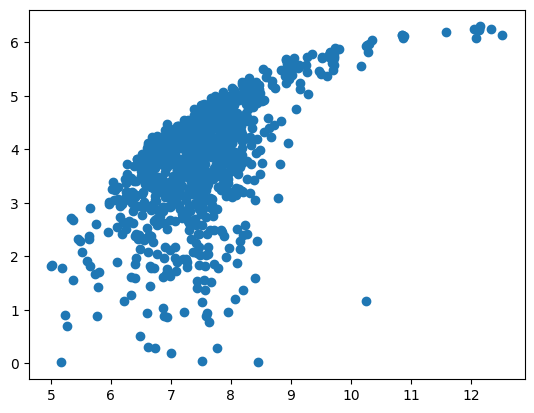

In [214]:
plt.scatter(ys, y_preds)

In [215]:
# inference on train pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_train.sample(1000).iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_1kg[s1].to(device)
    t2 = d_tensor_1kg[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG03603, NA21124, target: 7.898039690764618, distance: 4.306085109710693
Pair: NA20767, HG00337, target: 8.389814262086407, distance: 2.890347480773926
Pair: HG02496, HG03058, target: 7.913155185928067, distance: 4.671861171722412
Pair: HG03832, NA19247, target: 7.335633981927201, distance: 4.304865837097168
Pair: HG03809, HG02113, target: 6.551080335043404, distance: 3.2678773403167725
Pair: HG02184, NA19058, target: 6.228511003591183, distance: 3.4710607528686523
Pair: HG02131, NA18985, target: 8.40178233990491, distance: 5.062409400939941
Pair: NA19909, HG01863, target: 8.494538500851432, distance: 4.445708751678467
Pair: NA21088, NA19066, target: 10.382512863752321, distance: 5.965264797210693
Pair: HG00736, HG03653, target: 7.058758152518664, distance: 2.7327497005462646
Pair: NA07051, NA19719, target: 9.44375103564617, distance: 4.871711254119873
Pair: HG01354, HG02882, target: 7.67368812926773, distance: 3.5733563899993896
Pair: HG01384, NA20897, target: 7.065613363597717,

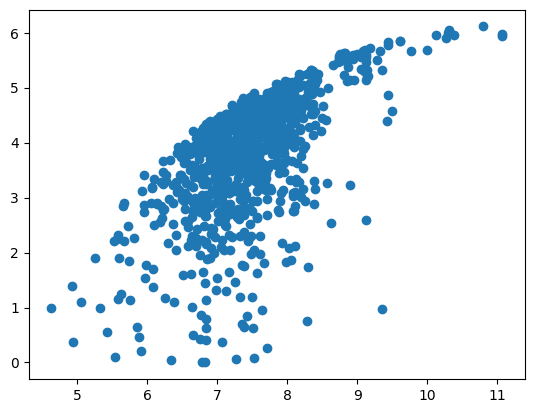

In [216]:

plt.scatter(ys, y_preds)

## Model global

In [7]:
d_tensor_1kg = torch.load("1kg-g2g-tensors.pt")
print(len(d_tensor_1kg))
list(d_tensor_1kg.items())[:5]

2535


[('NA18614', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG01918', tensor([1, 1, 1,  ..., 1, 1, 2], dtype=torch.int32)),
 ('NA18546', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)),
 ('HG02855', tensor([1, 1, 1,  ..., 1, 2, 1], dtype=torch.int32)),
 ('HG03565', tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32))]

In [8]:
d_tensor_pcawg = torch.load("pcawg-g2g-tensors.pt")
print(len(d_tensor_pcawg))
list(d_tensor_pcawg.items())[:5]

142


[('FI26317', tensor([1., 6., 6.,  ..., 8., 2., 1.])),
 ('FI22889', tensor([10., 12.,  5.,  ...,  9.,  2.,  1.])),
 ('FI45246', tensor([12., 11.,  8.,  ..., 19.,  8.,  1.])),
 ('FI19114', tensor([ 7.,  9., 10.,  ...,  7.,  9.,  5.])),
 ('FI45994', tensor([3., 5., 1.,  ..., 1., 1., 1.]))]

In [12]:
d_tensor_global = d_tensor_1kg.copy()
d_tensor_global.update(d_tensor_pcawg)
print(len(d_tensor_global))
print(d_tensor_global['FI10093'][0:5], d_tensor_global['HG00096'][0:5])

2677
tensor([ 3.,  5., 13.,  4.,  5.]) tensor([1, 1, 1, 1, 1], dtype=torch.int32)


In [13]:
# set tensor to float 32
for k,v in d_tensor_global.items():
    d_tensor_global[k] = v.to(torch.float32)

In [15]:
df_target_global = pd.read_csv("global-g2g_l2.tsv", sep="\t")
print(df_target_global.shape)
df_target_global.head()

(3581826, 3)


,l2,s_i,s_j
0,2099.0,NA18614,HG01918
1,2988.0,NA18614,NA18546
2,1381.0,NA18614,HG02855
3,1468.0,NA18614,HG03565
4,1244.0,NA18614,NA19324


<Axes: >

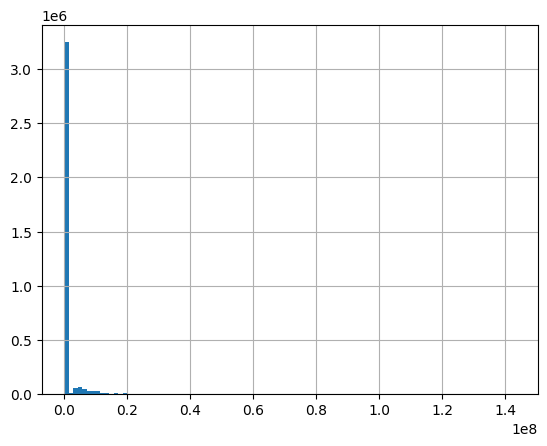

In [16]:
df_target_global['l2'].hist(bins=100)

- Note: standard scaler would center the targets around 0, however, I don't think it's straghtforward to z-score nomalize each embedding distance computed during training used to compute loss. There's probably a clever or complex way to do this, but it's out of the scope of this project. 

       l2      s_i      s_j    l2_log
0  2099.0  NA18614  HG01918  7.649693
1  2988.0  NA18614  NA18546  8.002694
2  1381.0  NA18614  HG02855  7.231287
3  1468.0  NA18614  HG03565  7.292337
4  1244.0  NA18614  NA19324  7.126891


Text(0.5, 1.0, 'Log l2 pairwise sqaured distances')

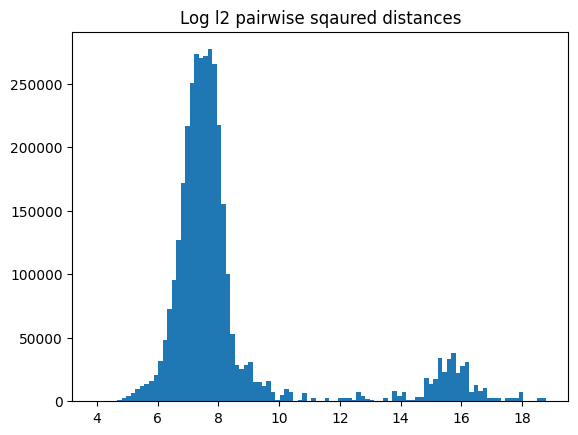

In [21]:
df_target_global['l2_log'] = df_target_global['l2'].apply(lambda x: np.log(x+1))
print(df_target_global.head())
df_target_global['l2_log'].hist(bins=100)
plt.grid(False)
plt.title('Log l2 pairwise sqaured distances')

### Split

In [26]:
target_1kg = pd.read_csv("1kg-g2g_l2.tsv", sep="\t")

In [33]:
# hold out 30% of samples from each population
p_samples_held_out = 0.3
n_held_out_1kg = int(np.floor(len(d_tensor_1kg) * p_samples_held_out))
n_held_out_pcawg = int(np.floor(len(d_tensor_pcawg) * p_samples_held_out))
print(n_held_out_1kg, n_held_out_pcawg)

760 42


In [53]:
test_samples_1kg = random.sample(list(d_tensor_1kg.keys()), n_held_out_1kg)
print(len(test_samples_1kg))
print(test_samples_1kg[:5])
test_samples_pcawg = random.sample(list(d_tensor_pcawg.keys()), n_held_out_pcawg)
print(len(test_samples_pcawg))
print(test_samples_pcawg[:5])

760
['HG02582', 'HG00304', 'HG00982', 'NA19314', 'NA19114']
42
['FI12251', 'FI31306', 'FI5477', 'FI33090', 'FI49945']


In [54]:
test_samples_global = test_samples_1kg + test_samples_pcawg
print(len(test_samples_global))

802


In [58]:
# exclude test samples
df_target_global_tr = df_target_global[
    (~df_target_global['s_i'].isin(test_samples_global)) & (~df_target_global['s_j'].isin(test_samples_global))
]
print(len(df_target_global_tr))
# show that the test samples are not in the train set
print(
    pd.concat([df_target_global_tr['s_i'], df_target_global_tr['s_j']]).nunique(), # total samples in train
    len(test_samples_global), # total samples in test
    len(d_tensor_global)  # total samples
)
df_target_global_tr.head()

1756875
1875 802 2677


,l2,s_i,s_j,l2_log
0,2099.0,NA18614,HG01918,7.649693
1,2988.0,NA18614,NA18546,8.002694
2,1381.0,NA18614,HG02855,7.231287
3,1468.0,NA18614,HG03565,7.292337
4,1244.0,NA18614,NA19324,7.126891


In [59]:
# get test data
df_target_global_te = df_target_global[
    df_target_global['s_i'].isin(test_samples_global) | df_target_global['s_j'].isin(test_samples_global)
]
df_target_global_te.shape

(1824951, 4)

In [61]:
print(df_target_global.shape, df_target_global_tr.shape, df_target_global_te.shape)
print(df_target_global_tr.shape[0] + df_target_global_te.shape[0])

(3581826, 4) (1756875, 4) (1824951, 4)
3581826


Note:

- Train requires both (and) samples NOT to be in the test set
- Test requires either (or) sample to be in the test set

### Curriculum 1 (within pop)

- Learn within population distances

In [130]:
# curriculum1 requires a delineation of which population each sample pair
# belongs to: {1kg, pcawg, mixed}

In [131]:
def label_pair_pop(s1, s2):
    if s1 in d_tensor_1kg.keys() and s2 in d_tensor_1kg.keys():
        return '1kg'
    if s1 in d_tensor_pcawg.keys() and s2 in d_tensor_pcawg.keys():
        return 'pcawg'
    return 'mixed'
# examples
# 1kg
s1 = 'NA18614'
s2 = 'HG01918'
print(label_pair_pop(s1, s2))
# pcawg
s1 = 'FI22889'
s2 = 'FI35724'
print(label_pair_pop(s1,s2))
# mixed
s1 = 'NA19461'
s2 = 'FI35724'
print(label_pair_pop(s1,s2))
    

1kg
pcawg
mixed


In [132]:
df_target_global_tr['pop'] = df_target_global_tr.apply(lambda x: label_pair_pop(x['s_i'], x['s_j']), axis=1)
df_target_global_tr.head()

/tmp/ipykernel_15777/1683449697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_global_tr['pop'] = df_target_global_tr.apply(lambda x: label_pair_pop(x['s_i'], x['s_j']), axis=1)


,l2,s_i,s_j,l2_log,pop
0,2099.0,NA18614,HG01918,7.649693,1kg
1,2988.0,NA18614,NA18546,8.002694,1kg
2,1381.0,NA18614,HG02855,7.231287,1kg
3,1468.0,NA18614,HG03565,7.292337,1kg
4,1244.0,NA18614,NA19324,7.126891,1kg


pop
1kg      1574425
mixed     177500
pcawg       4950
Name: count, dtype: int64


<Axes: xlabel='pop'>

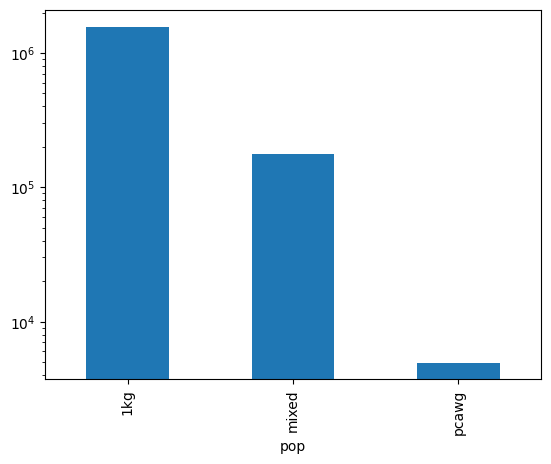

In [133]:
print(df_target_global_tr['pop'].value_counts())
df_target_global_tr['pop'].value_counts().plot(kind='bar', logy=True)

- Let's ensure that the model sees at a balanced amount of samples from each population in each batch

In [136]:
class SiameseDatasetC1(Dataset):
    def __init__(self, d_tensor, df_target, n_samples=1000, scaled_target=True):
        self.d_tensor = d_tensor
        self.df_target = df_target
        # n samples will define the total length of the dataset
        # we could insted use the length of the dataset (which is the number of samples)
        # len(d_tensor), but this is a lot of data per epoch
        # instead, a sampling pairs approach is used
        self.n_samples = n_samples
        self.scaled_target = scaled_target
        self.last_pop = None # track the population of latest pair

    def __len__(self):
        return self.n_samples
        # return len(d_tensor.items())

    def __getitem__(self, idx):
        # sample from the target dataframe
        # such that the population is the different from the last pair
        if self.last_pop is None: # random 1st pair
            pair = self.df_target.sample(1)
            self.last_pop = pair['pop'].values[0]
        elif self.last_pop == '1kg': # sample from pcawg
            pair = self.df_target[self.df_target['pop'] == 'pcawg'].sample(1)
            self.last_pop = pair['pop'].values[0]
        elif self.last_pop == 'pcawg': # sample from 1kg
            pair = self.df_target[self.df_target['pop'] == '1kg'].sample(1)
            self.last_pop = pair['pop'].values[0]
        else:
            raise ValueError("Invalid population")
        s1 = pair["s_i"].values[0]
        t1 = self.d_tensor[s1]
        s2 = pair["s_j"].values[0]
        t2 = self.d_tensor[s2]
        if self.scaled_target:
            target = torch.tensor(pair["l2_log"].values[0], dtype=torch.float32)
        else:
            target = torch.tensor(pair["l2"].values[0], dtype=torch.float32)
        return t1, t2, target

In [137]:
# dataset_c1 = SiameseDatasetC1(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# next(iter(dataset_c1))
# print(dataset_c1.last_pop)
# print(next(iter(dataset_c1)))

In [138]:
dataset_c1 = SiameseDatasetC1(d_tensor_global, df_target_global_tr, n_samples=1000, scaled_target=True)
dataloader_c1 = DataLoader(dataset_c1, batch_size=256, shuffle=True)

In [139]:
input_dim = d_tensor_1kg["HG00096"].shape[0]
embedding_dim = 512
print(input_dim,embedding_dim)
model = SiameseNetwork(input_dim, embedding_dim)
model.to(device)
criterion = CustomMSELoss(scaled_target=False) # using log scaled l2
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

18721 512


In [140]:
torch.set_num_threads(15) # using gpu, but set this just in case
writer = SummaryWriter(log_dir="logs")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    l = []
    for i, data in enumerate(dataloader_c1):
        t1, t2, target = data
        t1, t2, target = t1.to(device), t2.to(device), target.to(device)
        # reset grad    
        optimizer.zero_grad()
        output1, output2 = model(t1, t2)
        embedding_distance = torch.sum((output1 - output2) ** 2, dim=1) # squared l2
        loss = criterion(embedding_distance, target)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        running_loss += loss.item()
        print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader_c1) + i)
    print(f"Epoch {epoch+1}, loss: {running_loss}")
writer.close()

Epoch 1, batch 1, loss: 5404947.0
Epoch 1, batch 2, loss: 15893485568.0
Epoch 1, batch 3, loss: 10986417152.0
Epoch 1, batch 4, loss: 1355503744.0
Epoch 1, loss: 28240811411.0
Epoch 2, batch 1, loss: 85599520.0
Epoch 2, batch 2, loss: 502329152.0
Epoch 2, batch 3, loss: 16879710.0
Epoch 2, batch 4, loss: 393620512.0
Epoch 2, loss: 998428894.0
Epoch 3, batch 1, loss: 57702432.0
Epoch 3, batch 2, loss: 236896112.0
Epoch 3, batch 3, loss: 77216608.0
Epoch 3, batch 4, loss: 24964996.0
Epoch 3, loss: 396780148.0
Epoch 4, batch 1, loss: 36576320.0
Epoch 4, batch 2, loss: 11459123.0
Epoch 4, batch 3, loss: 14429703.0
Epoch 4, batch 4, loss: 1244727.25
Epoch 4, loss: 63709873.25
Epoch 5, batch 1, loss: 4840818.5
Epoch 5, batch 2, loss: 2117931.5
Epoch 5, batch 3, loss: 3472693.5
Epoch 5, batch 4, loss: 5787607.5
Epoch 5, loss: 16219051.0
Epoch 6, batch 1, loss: 2409958.5
Epoch 6, batch 2, loss: 849278.5
Epoch 6, batch 3, loss: 1428340.25
Epoch 6, batch 4, loss: 482457.5
Epoch 6, loss: 5170034.

In [143]:
torch.save(model.state_dict(), "siamese_c1.pt")

- This doesn't seem to work well. Maybe try learning within population distances first

In [142]:
df_target_global_te_sub = df_target_global_te.sample(1000, random_state=0)
print(df_target_global_te_sub.shape)
df_target_global_te_sub.head()

(1000, 4)


,l2,s_i,s_j,l2_log
807097,1595.0,HG03160,HG03079,7.375256
3109033,1679.0,HG03695,HG01809,7.426549
527350,3918.0,HG03615,HG02095,8.273592
3063748,7670.0,HG00238,NA19625,8.945202
3300482,10831515.0,HG02139,FI33072,16.197971


In [146]:
# inference on test pairs
ys = []
y_preds = []
model.eval()
for i, row in df_target_global_te_sub.iterrows():
    s1 = row['s_i']
    s2 = row['s_j']
    t1 = d_tensor_global[s1].to(device)
    t2 = d_tensor_global[s2].to(device)
    output1, output2 = model(t1, t2)
    embedding_distance = torch.log10(torch.sum((output1 - output2) ** 2) + 1)
    y = row['l2_log']
    y_pred = embedding_distance.item()
    ys.append(y)
    y_preds.append(y_pred)
    print(f"Pair: {s1}, {s2}, target: {row['l2_log']}, distance: {embedding_distance.item()}")

Pair: HG03160, HG03079, target: 7.375255778009754, distance: 0.0009276934433728456
Pair: HG03695, HG01809, target: 7.426549072397305, distance: 0.002232765778899193
Pair: HG03615, HG02095, target: 8.27359179819963, distance: 0.003834235481917858
Pair: HG00238, NA19625, target: 8.945202263959295, distance: 0.017780287191271782
Pair: HG02139, FI33072, target: 16.197970590713453, distance: 2.3904716968536377
Pair: NA18516, FI11979, target: 15.741213772287884, distance: 2.0518112182617188
Pair: HG02265, HG02079, target: 7.017506142941256, distance: 0.002341482089832425
Pair: HG04063, HG02976, target: 6.61472560020376, distance: 0.0013482208596542478
Pair: HG01682, HG01595, target: 6.741700694652054, distance: 0.0021238159388303757
Pair: HG02388, HG03039, target: 8.299534570332597, distance: 0.006972596049308777
Pair: NA19436, HG02025, target: 8.066207568006263, distance: 0.008317863568663597
Pair: NA11831, HG02427, target: 8.49596955496461, distance: 0.014059620909392834
Pair: HG02604, HG0

In [154]:
# compute embeddings for all samples in global df
c1_embeddings = []
index = []
for k,v in d_tensor_global.items():
    t = v.to(device)
    e = model.forward_one(t)
    index.append(k)
    c1_embeddings.append(e.cpu().detach().numpy())
df_c1_embeddings = pd.DataFrame(c1_embeddings)
df_c1_embeddings.index = index
df_c1_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
NA18614,0.014219,0.027213,0.072178,0.029255,0.047309,0.045635,0.031951,0.090546,0.030165,-0.025394,...,-0.054527,0.056184,0.031840,-0.031084,-0.042337,-0.077955,-0.190528,-0.036451,0.022287,-0.050690
HG01918,0.014127,0.024504,0.070981,0.028601,0.045705,0.045190,0.034703,0.086800,0.032409,-0.024050,...,-0.054661,0.054443,0.033029,-0.032609,-0.039989,-0.076226,-0.186768,-0.033745,0.020420,-0.049852
NA18546,0.015998,0.024767,0.077645,0.030433,0.048853,0.047572,0.032777,0.091679,0.032268,-0.016459,...,-0.063047,0.059349,0.033292,-0.028980,-0.042879,-0.076901,-0.196227,-0.040019,0.020811,-0.054597
HG02855,0.012336,0.029015,0.073515,0.028105,0.045317,0.040602,0.030779,0.088841,0.033010,-0.025110,...,-0.051448,0.053601,0.035430,-0.030885,-0.042076,-0.076600,-0.191332,-0.035685,0.018388,-0.050529
HG03565,0.013048,0.027831,0.070237,0.027979,0.045043,0.040536,0.032922,0.088000,0.032489,-0.025590,...,-0.051338,0.052197,0.033277,-0.031271,-0.042037,-0.075027,-0.188989,-0.033524,0.017458,-0.049533


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


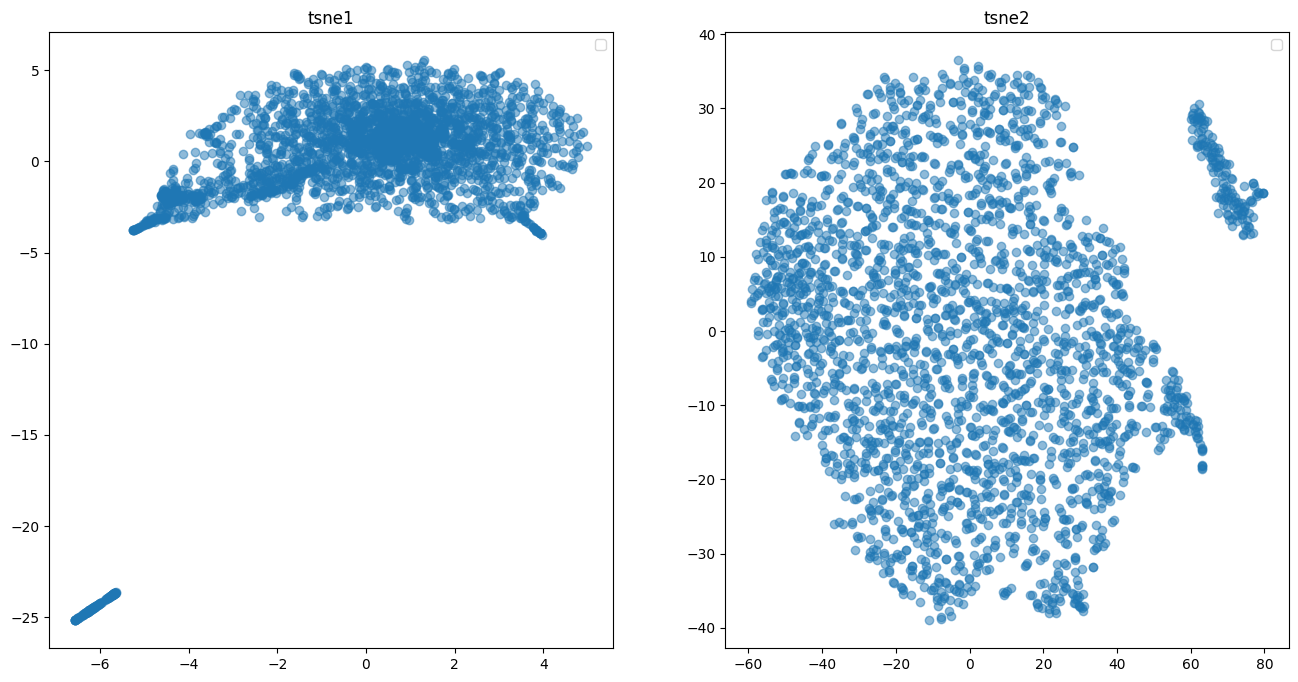

In [155]:
def tsne_contrastive(df1, df2,figtitle=None,  title1='tsne1', title2='tsne2', samples=None):
    # df 1
    tsne1 = TSNE(n_components=2, random_state=0)
    df_tsne1 = pd.DataFrame(tsne1.fit_transform(df1))
    df_tsne1.index = df1.index

    tsne2 = TSNE(n_components=2, random_state=0)
    df_tsne2 = pd.DataFrame(tsne2.fit_transform(df2))
    df_tsne2.index = df2.index

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].scatter(df_tsne1.iloc[:, 0], df_tsne1.iloc[:, 1], alpha=0.5)
    axes[0].set_title(title1)
    if samples:
        for i in samples:
            axes[0].scatter(
                df_tsne1.loc[i, 0], df_tsne1.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df1.loc[samples[0]] - df1.loc[samples[1]]) ** 2
        axes[0].set_title(f"{title1}\nSamples' squared L2 distance: {d:.2f}")
    axes[0].legend()

    # df 2
    axes[1].scatter(df_tsne2.iloc[:, 0], df_tsne2.iloc[:, 1], alpha=0.5)
    axes[1].set_title(title2)
    if samples:
        for i in samples:
            axes[1].scatter(
                df_tsne2.loc[i, 0], df_tsne2.loc[i, 1], color="red", s=50, label=i
            )
        # squared l2 distance
        d = np.linalg.norm(df2.loc[samples[0]] - df2.loc[samples[1]]) ** 2
        axes[1].set_title(f"{title2}\nSamples' squared L2 distance: {d:.2f}")
    axes[1].legend()
    if figtitle:
        fig.suptitle(figtitle)
# note: rmse is computed below
tsne_contrastive(df_global, df_c1_embeddings) #figtitle=f'MSE={mse_jl_eps_01:.2f}', title1='Original TSNE', title2=f'Johnson-Lindenstrauss TSNE (Epsilon={epsilon}, k={k})', samples=(i1,i2))